# SPCBViTNet – Adagrad Ablation

📌 Part of the ablation study for the submission:  
**"SPCBViTNet: A Self-Parallel Convolutional Block with Vision Transformers for Skin Cancer Classification"**

🔒 Not yet peer-reviewed. For review only.  
📁 [GitHub Repo](https://github.com/diyagoyal31/SPCBViT)


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:
from torchvision import transforms
from PIL import Image
class SkinCancerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform  # Default transform applied in __getitem__
        self.image_paths = []
        self.labels = []

        self.class_names = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.class_names)}

        for cls_name in self.class_names:
            cls_folder = os.path.join(root_dir, cls_name)
            for img_name in os.listdir(cls_folder):
                img_path = os.path.join(cls_folder, img_name)
                if img_path.lower().endswith(('.jpg', '.jpeg', '.png')):  # Supports multiple formats
                    self.image_paths.append(img_path)
                    self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load and convert image
        image = Image.open(img_path).convert("RGB")

        # Apply transform (if provided), otherwise apply default ToTensor
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)

        return image, torch.tensor(label, dtype=torch.long)

In [4]:
import torchvision.transforms.functional as TF
import random

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SKFeaturePyramid(nn.Module):
    def __init__(self, in_channels):
        super(SKFeaturePyramid, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.conv3 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels, in_channels, kernel_size=5, padding=2)
        self.fc = nn.Linear(in_channels, 3)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        f1 = self.conv1(x)
        f2 = self.conv3(x)
        f3 = self.conv5(x)
        f_sum = f1 + f2 + f3
        f_weights = self.softmax(self.fc(f_sum.mean(dim=(2, 3)))).unsqueeze(-1).unsqueeze(-1)
        return f1 * f_weights[:, 0].view(-1, 1, 1, 1) + \
               f2 * f_weights[:, 1].view(-1, 1, 1, 1) + \
               f3 * f_weights[:, 2].view(-1, 1, 1, 1)


class SelfInteractiveAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfInteractiveAttention, self).__init__()
        self.channel_attn = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels, kernel_size=1),
            nn.Sigmoid()
        )
        self.spatial_attn = nn.Conv2d(in_channels, 1, kernel_size=7, padding=3)

    def forward(self, x):
        ca = self.channel_attn(x) * x
        sa = torch.sigmoid(self.spatial_attn(x)) * x
        return ca + sa


class HigherOrderInteraction(nn.Module):
    def __init__(self, in_channels1, in_channels2, out_channels):
        super(HigherOrderInteraction, self).__init__()
        self.conv1 = nn.Conv2d(in_channels1, out_channels, kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels2, out_channels, kernel_size=1)
        self.bilinear_pool = nn.Conv2d(out_channels, out_channels, kernel_size=1)
        self.trilinear_pool = nn.Conv2d(out_channels, out_channels, kernel_size=1)

    def forward(self, x1, x2):
        x1 = self.conv1(x1)
        x2 = self.conv2(x2)
        if x1.shape[2:] != x2.shape[2:]:
            x2 = F.interpolate(x2, size=x1.shape[2:], mode='bilinear', align_corners=False)
        return self.bilinear_pool(x1 * x2) + self.trilinear_pool(x1 + x2)


class SPCBViTNet(nn.Module):
    def __init__(self, vit_model, num_classes, patch_grid=(14, 14)):
        super(SPCBViTNet, self).__init__()
        self.vit_model = vit_model
        self.hidden_size = vit_model.config.hidden_size
        self.patch_grid = patch_grid  # E.g. 14x14 for ViT-B/16

        # SPCB modules
        self.sk = SKFeaturePyramid(self.hidden_size)
        self.attn = SelfInteractiveAttention(self.hidden_size)
        self.higher_order = HigherOrderInteraction(self.hidden_size, self.hidden_size, self.hidden_size)

        self.global_avg = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(self.hidden_size, 512),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        vit_out = self.vit_model(pixel_values=x).last_hidden_state  # [B, N+1, C]
        cls_token = vit_out[:, 0]  # CLS token
        patch_tokens = vit_out[:, 1:]  # [B, N, C]

        # Convert patch tokens to 2D feature maps
        B, N, C = patch_tokens.size()
        H, W = self.patch_grid
        patch_map = patch_tokens.permute(0, 2, 1).contiguous().view(B, C, H, W)

        # SPCB modules
        f1 = self.sk(patch_map)
        f2 = self.attn(f1)
        f3 = self.higher_order(f1, f2)

        out = self.global_avg(f3).view(B, -1)
        return self.classifier(out)


In [6]:
from transformers import ViTModel

vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

model = SPCBViTNet(vit_model=vit_model, num_classes=7, patch_grid=(14, 14))


/home/lab115/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from torchvision import transforms
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from torch.optim import Adagrad
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

# ✅ Data Augmentation for Training
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
])

# ✅ Only Tensor + Normalization for Testing
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load full dataset (with neutral transform for indexing)
base_dataset = SkinCancerDataset(root_dir="/home/lab115/Downloads/dataset/dataset", transform=transforms.ToTensor())

NUM_CLASSES = len(base_dataset.class_to_idx)
BATCH_SIZE = 32
EPOCHS = 50
K_FOLDS = 10
LEARNING_RATE = 0.0001

# Extract labels to stratify
targets = [base_dataset[i][1] for i in range(len(base_dataset))]

skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
splits = list(skf.split(np.zeros(len(targets)), targets))

all_true_labels = []
all_pred_labels = []
all_probs = []

for fold, (train_idx, test_idx) in enumerate(splits):
    print(f"\n🚀 Training Fold {fold + 1}/{K_FOLDS}")

    # Separate datasets to avoid transform leakage
    train_dataset = SkinCancerDataset(root_dir="/home/lab115/Downloads/dataset/dataset", transform=train_transform)
    test_dataset = SkinCancerDataset(root_dir="/home/lab115/Downloads/dataset/dataset", transform=test_transform)

    train_subset = Subset(train_dataset, train_idx)
    test_subset = Subset(test_dataset, test_idx)

    # Data loaders
    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    # Initialize model
    model = SPCBViTNet(vit_model=vit_model, num_classes=NUM_CLASSES).to(device)

    # Optimizer & Loss
    optimizer = Adagrad(model.parameters(), lr=LEARNING_RATE)
    criterion = CrossEntropyLoss()

    # Checkpoint path
    checkpoint_path = f"best_model_fold_{fold + 1}.pth"

    # Load checkpoint if available
    best_acc = 0.0
    start_epoch = 0
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        start_epoch = checkpoint["epoch"] + 1
        best_acc = checkpoint["best_acc"]
        print(f"🔄 Resuming from epoch {start_epoch}, best accuracy: {best_acc:.2f}%")

    # Training Loop
    for epoch in range(start_epoch, EPOCHS):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        loop = tqdm(train_loader, leave=True)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loop.set_description(f"Epoch [{epoch+1}/{EPOCHS}]")
            loop.set_postfix(loss=loss.item(), acc=100 * correct / total)

        # Testing Loop
        model.eval()
        test_correct, test_total = 0, 0
        fold_preds, fold_labels, fold_probs = [], [], []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                probs = torch.nn.functional.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs, 1)

                fold_preds.extend(predicted.cpu().numpy())
                fold_labels.extend(labels.cpu().numpy())
                fold_probs.extend(probs.cpu().numpy())

                test_correct += (predicted == labels).sum().item()
                test_total += labels.size(0)

        test_acc = 100 * test_correct / test_total
        print(f"✅ Fold {fold+1}: Test Accuracy = {test_acc:.2f}%")

        # Save checkpoint if accuracy improves
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "best_acc": best_acc,
            }, checkpoint_path)
            print(f"🎯 New best model saved with accuracy: {best_acc:.2f}%")

    all_true_labels.extend(fold_labels)
    all_pred_labels.extend(fold_preds)
    all_probs.extend(fold_probs)



🚀 Training Fold 1/10


Epoch [1/50]: 100%|█████| 282/282 [01:27<00:00,  3.23it/s, acc=71.7, loss=0.306]


✅ Fold 1: Test Accuracy = 75.35%
🎯 New best model saved with accuracy: 75.35%


Epoch [2/50]: 100%|█████| 282/282 [01:26<00:00,  3.27it/s, acc=76.5, loss=0.703]


✅ Fold 1: Test Accuracy = 78.54%
🎯 New best model saved with accuracy: 78.54%


Epoch [3/50]: 100%|███████| 282/282 [01:26<00:00,  3.27it/s, acc=79, loss=0.717]


✅ Fold 1: Test Accuracy = 78.74%
🎯 New best model saved with accuracy: 78.74%


Epoch [4/50]: 100%|█████| 282/282 [01:26<00:00,  3.25it/s, acc=79.7, loss=0.425]


✅ Fold 1: Test Accuracy = 79.54%
🎯 New best model saved with accuracy: 79.54%


Epoch [5/50]: 100%|█████| 282/282 [01:26<00:00,  3.25it/s, acc=80.8, loss=0.821]


✅ Fold 1: Test Accuracy = 80.34%
🎯 New best model saved with accuracy: 80.34%


Epoch [6/50]: 100%|█████| 282/282 [01:26<00:00,  3.25it/s, acc=81.9, loss=0.633]


✅ Fold 1: Test Accuracy = 81.44%
🎯 New best model saved with accuracy: 81.44%


Epoch [7/50]: 100%|█████| 282/282 [01:26<00:00,  3.25it/s, acc=82.5, loss=0.502]


✅ Fold 1: Test Accuracy = 81.14%


Epoch [8/50]: 100%|█████| 282/282 [01:27<00:00,  3.24it/s, acc=83.1, loss=0.234]


✅ Fold 1: Test Accuracy = 81.74%
🎯 New best model saved with accuracy: 81.74%


Epoch [9/50]: 100%|█████| 282/282 [01:26<00:00,  3.24it/s, acc=83.6, loss=0.223]


✅ Fold 1: Test Accuracy = 82.63%
🎯 New best model saved with accuracy: 82.63%


Epoch [10/50]: 100%|████| 282/282 [01:26<00:00,  3.24it/s, acc=84.3, loss=0.269]


✅ Fold 1: Test Accuracy = 83.33%
🎯 New best model saved with accuracy: 83.33%


Epoch [11/50]: 100%|█████| 282/282 [01:26<00:00,  3.24it/s, acc=84.5, loss=0.78]


✅ Fold 1: Test Accuracy = 82.93%


Epoch [12/50]: 100%|████| 282/282 [01:27<00:00,  3.24it/s, acc=85.3, loss=0.489]


✅ Fold 1: Test Accuracy = 83.03%


Epoch [13/50]: 100%|████| 282/282 [01:27<00:00,  3.23it/s, acc=85.7, loss=0.125]


✅ Fold 1: Test Accuracy = 83.23%


Epoch [14/50]: 100%|████| 282/282 [01:27<00:00,  3.23it/s, acc=86.2, loss=0.496]


✅ Fold 1: Test Accuracy = 82.63%


Epoch [15/50]: 100%|████| 282/282 [01:27<00:00,  3.23it/s, acc=86.4, loss=0.296]


✅ Fold 1: Test Accuracy = 84.13%
🎯 New best model saved with accuracy: 84.13%


Epoch [16/50]: 100%|████| 282/282 [01:27<00:00,  3.24it/s, acc=86.6, loss=0.285]


✅ Fold 1: Test Accuracy = 84.53%
🎯 New best model saved with accuracy: 84.53%


Epoch [17/50]: 100%|████| 282/282 [01:27<00:00,  3.24it/s, acc=87.2, loss=0.208]


✅ Fold 1: Test Accuracy = 83.93%


Epoch [18/50]: 100%|████| 282/282 [01:27<00:00,  3.24it/s, acc=87.6, loss=0.538]


✅ Fold 1: Test Accuracy = 84.43%


Epoch [19/50]: 100%|█████| 282/282 [01:27<00:00,  3.24it/s, acc=87.6, loss=0.38]


✅ Fold 1: Test Accuracy = 84.33%


Epoch [20/50]: 100%|████| 282/282 [01:27<00:00,  3.23it/s, acc=88.1, loss=0.191]


✅ Fold 1: Test Accuracy = 85.23%
🎯 New best model saved with accuracy: 85.23%


Epoch [21/50]: 100%|██████| 282/282 [01:26<00:00,  3.25it/s, acc=88.6, loss=0.6]


✅ Fold 1: Test Accuracy = 84.13%


Epoch [22/50]: 100%|████| 282/282 [01:27<00:00,  3.24it/s, acc=88.5, loss=0.225]


✅ Fold 1: Test Accuracy = 85.13%


Epoch [23/50]: 100%|████| 282/282 [01:27<00:00,  3.22it/s, acc=88.8, loss=0.161]


✅ Fold 1: Test Accuracy = 84.53%


Epoch [24/50]: 100%|████| 282/282 [01:28<00:00,  3.18it/s, acc=89.1, loss=0.226]


✅ Fold 1: Test Accuracy = 84.73%


Epoch [25/50]: 100%|████| 282/282 [01:28<00:00,  3.19it/s, acc=89.3, loss=0.451]


✅ Fold 1: Test Accuracy = 84.13%


Epoch [26/50]: 100%|███| 282/282 [01:27<00:00,  3.24it/s, acc=89.9, loss=0.0666]


✅ Fold 1: Test Accuracy = 84.83%


Epoch [27/50]: 100%|██████| 282/282 [01:26<00:00,  3.25it/s, acc=90, loss=0.154]


✅ Fold 1: Test Accuracy = 84.53%


Epoch [28/50]: 100%|████| 282/282 [01:26<00:00,  3.25it/s, acc=90.4, loss=0.307]


✅ Fold 1: Test Accuracy = 85.13%


Epoch [29/50]: 100%|████| 282/282 [01:26<00:00,  3.25it/s, acc=89.8, loss=0.198]


✅ Fold 1: Test Accuracy = 84.43%


Epoch [30/50]: 100%|████| 282/282 [01:26<00:00,  3.25it/s, acc=90.6, loss=0.294]


✅ Fold 1: Test Accuracy = 84.83%


Epoch [31/50]: 100%|████| 282/282 [01:26<00:00,  3.25it/s, acc=90.9, loss=0.366]


✅ Fold 1: Test Accuracy = 85.33%
🎯 New best model saved with accuracy: 85.33%


Epoch [32/50]: 100%|████| 282/282 [01:26<00:00,  3.25it/s, acc=91.1, loss=0.315]


✅ Fold 1: Test Accuracy = 84.73%


Epoch [33/50]: 100%|████| 282/282 [01:27<00:00,  3.24it/s, acc=91.3, loss=0.308]


✅ Fold 1: Test Accuracy = 84.93%


Epoch [34/50]: 100%|█████| 282/282 [01:27<00:00,  3.24it/s, acc=91, loss=0.0831]


✅ Fold 1: Test Accuracy = 84.33%


Epoch [35/50]: 100%|████| 282/282 [01:27<00:00,  3.24it/s, acc=91.7, loss=0.418]


✅ Fold 1: Test Accuracy = 84.33%


Epoch [36/50]: 100%|████| 282/282 [01:27<00:00,  3.24it/s, acc=91.9, loss=0.145]


✅ Fold 1: Test Accuracy = 85.33%


Epoch [37/50]: 100%|████| 282/282 [01:27<00:00,  3.24it/s, acc=91.9, loss=0.188]


✅ Fold 1: Test Accuracy = 86.03%
🎯 New best model saved with accuracy: 86.03%


Epoch [38/50]: 100%|█████| 282/282 [01:26<00:00,  3.25it/s, acc=92.3, loss=0.16]


✅ Fold 1: Test Accuracy = 85.93%


Epoch [39/50]: 100%|████| 282/282 [01:27<00:00,  3.24it/s, acc=92.4, loss=0.165]


✅ Fold 1: Test Accuracy = 86.13%
🎯 New best model saved with accuracy: 86.13%


Epoch [40/50]: 100%|███| 282/282 [01:26<00:00,  3.24it/s, acc=92.7, loss=0.0667]


✅ Fold 1: Test Accuracy = 86.33%
🎯 New best model saved with accuracy: 86.33%


Epoch [41/50]: 100%|████| 282/282 [01:26<00:00,  3.24it/s, acc=92.4, loss=0.236]


✅ Fold 1: Test Accuracy = 85.93%


Epoch [42/50]: 100%|████| 282/282 [01:27<00:00,  3.23it/s, acc=92.6, loss=0.107]


✅ Fold 1: Test Accuracy = 85.63%


Epoch [43/50]: 100%|████| 282/282 [01:27<00:00,  3.24it/s, acc=92.9, loss=0.131]


✅ Fold 1: Test Accuracy = 85.03%


Epoch [44/50]: 100%|████| 282/282 [01:27<00:00,  3.24it/s, acc=93.2, loss=0.507]


✅ Fold 1: Test Accuracy = 85.73%


Epoch [45/50]: 100%|████| 282/282 [01:27<00:00,  3.24it/s, acc=93.4, loss=0.122]


✅ Fold 1: Test Accuracy = 86.13%


Epoch [46/50]: 100%|████| 282/282 [01:27<00:00,  3.24it/s, acc=93.3, loss=0.309]


✅ Fold 1: Test Accuracy = 85.93%


Epoch [47/50]: 100%|███| 282/282 [01:27<00:00,  3.23it/s, acc=93.5, loss=0.0876]


✅ Fold 1: Test Accuracy = 85.23%


Epoch [48/50]: 100%|████| 282/282 [01:27<00:00,  3.23it/s, acc=93.7, loss=0.288]


✅ Fold 1: Test Accuracy = 85.13%


Epoch [49/50]: 100%|████| 282/282 [01:27<00:00,  3.23it/s, acc=93.5, loss=0.121]


✅ Fold 1: Test Accuracy = 86.73%
🎯 New best model saved with accuracy: 86.73%


Epoch [50/50]: 100%|███| 282/282 [01:27<00:00,  3.24it/s, acc=93.4, loss=0.0728]


✅ Fold 1: Test Accuracy = 85.83%

🚀 Training Fold 2/10


Epoch [1/50]: 100%|█████| 282/282 [01:27<00:00,  3.23it/s, acc=81.7, loss=0.117]


✅ Fold 2: Test Accuracy = 86.83%
🎯 New best model saved with accuracy: 86.83%


Epoch [2/50]: 100%|█████| 282/282 [01:27<00:00,  3.23it/s, acc=88.4, loss=0.286]


✅ Fold 2: Test Accuracy = 88.42%
🎯 New best model saved with accuracy: 88.42%


Epoch [3/50]: 100%|█████| 282/282 [01:26<00:00,  3.24it/s, acc=90.5, loss=0.205]


✅ Fold 2: Test Accuracy = 89.22%
🎯 New best model saved with accuracy: 89.22%


Epoch [4/50]: 100%|█████| 282/282 [01:26<00:00,  3.24it/s, acc=91.7, loss=0.248]


✅ Fold 2: Test Accuracy = 89.52%
🎯 New best model saved with accuracy: 89.52%


Epoch [5/50]: 100%|█████| 282/282 [01:27<00:00,  3.24it/s, acc=92.9, loss=0.263]


✅ Fold 2: Test Accuracy = 89.02%


Epoch [6/50]: 100%|████| 282/282 [01:27<00:00,  3.23it/s, acc=93.2, loss=0.0606]


✅ Fold 2: Test Accuracy = 89.82%
🎯 New best model saved with accuracy: 89.82%


Epoch [7/50]: 100%|█████| 282/282 [01:27<00:00,  3.24it/s, acc=93.5, loss=0.108]


✅ Fold 2: Test Accuracy = 89.72%


Epoch [8/50]: 100%|█████| 282/282 [01:27<00:00,  3.23it/s, acc=94.1, loss=0.157]


✅ Fold 2: Test Accuracy = 89.82%


Epoch [9/50]: 100%|█████| 282/282 [01:27<00:00,  3.23it/s, acc=94.4, loss=0.166]


✅ Fold 2: Test Accuracy = 90.12%
🎯 New best model saved with accuracy: 90.12%


Epoch [10/50]: 100%|████| 282/282 [01:27<00:00,  3.24it/s, acc=94.6, loss=0.121]


✅ Fold 2: Test Accuracy = 91.72%
🎯 New best model saved with accuracy: 91.72%


Epoch [11/50]: 100%|████| 282/282 [01:27<00:00,  3.24it/s, acc=95.2, loss=0.571]


✅ Fold 2: Test Accuracy = 90.22%


Epoch [12/50]: 100%|███| 282/282 [01:27<00:00,  3.23it/s, acc=94.9, loss=0.0471]


✅ Fold 2: Test Accuracy = 90.42%


Epoch [13/50]: 100%|████| 282/282 [01:27<00:00,  3.23it/s, acc=95.6, loss=0.146]


✅ Fold 2: Test Accuracy = 90.82%


Epoch [14/50]: 100%|████| 282/282 [01:27<00:00,  3.23it/s, acc=95.3, loss=0.128]


✅ Fold 2: Test Accuracy = 91.82%
🎯 New best model saved with accuracy: 91.82%


Epoch [15/50]: 100%|███| 282/282 [01:27<00:00,  3.24it/s, acc=95.7, loss=0.0447]


✅ Fold 2: Test Accuracy = 91.42%


Epoch [16/50]: 100%|████| 282/282 [01:27<00:00,  3.23it/s, acc=96.2, loss=0.279]


✅ Fold 2: Test Accuracy = 91.92%
🎯 New best model saved with accuracy: 91.92%


Epoch [17/50]: 100%|██| 282/282 [01:27<00:00,  3.23it/s, acc=96.1, loss=0.00685]


✅ Fold 2: Test Accuracy = 90.72%


Epoch [18/50]: 100%|████| 282/282 [01:27<00:00,  3.23it/s, acc=96.1, loss=0.315]


✅ Fold 2: Test Accuracy = 89.72%


Epoch [19/50]: 100%|███| 282/282 [01:27<00:00,  3.23it/s, acc=96.7, loss=0.0764]


✅ Fold 2: Test Accuracy = 91.12%


Epoch [20/50]: 100%|███| 282/282 [01:27<00:00,  3.23it/s, acc=96.7, loss=0.0416]


✅ Fold 2: Test Accuracy = 91.12%


Epoch [21/50]: 100%|███| 282/282 [01:27<00:00,  3.23it/s, acc=96.8, loss=0.0608]


✅ Fold 2: Test Accuracy = 90.92%


Epoch [22/50]: 100%|███████| 282/282 [01:27<00:00,  3.23it/s, acc=97, loss=0.13]


✅ Fold 2: Test Accuracy = 90.52%


Epoch [23/50]: 100%|███| 282/282 [01:27<00:00,  3.23it/s, acc=96.7, loss=0.0977]


✅ Fold 2: Test Accuracy = 90.32%


Epoch [24/50]: 100%|███| 282/282 [01:27<00:00,  3.23it/s, acc=96.9, loss=0.0593]


✅ Fold 2: Test Accuracy = 90.92%


Epoch [25/50]: 100%|████| 282/282 [01:27<00:00,  3.23it/s, acc=97, loss=0.00787]


✅ Fold 2: Test Accuracy = 91.12%


Epoch [26/50]: 100%|████| 282/282 [01:27<00:00,  3.23it/s, acc=97.2, loss=0.373]


✅ Fold 2: Test Accuracy = 91.22%


Epoch [27/50]: 100%|██| 282/282 [01:27<00:00,  3.23it/s, acc=97.4, loss=0.00694]


✅ Fold 2: Test Accuracy = 90.72%


Epoch [28/50]: 100%|█████| 282/282 [01:27<00:00,  3.23it/s, acc=97.3, loss=0.13]


✅ Fold 2: Test Accuracy = 90.52%


Epoch [29/50]: 100%|████| 282/282 [01:27<00:00,  3.23it/s, acc=97.6, loss=0.021]


✅ Fold 2: Test Accuracy = 90.62%


Epoch [30/50]: 100%|███| 282/282 [01:27<00:00,  3.23it/s, acc=97.2, loss=0.0986]


✅ Fold 2: Test Accuracy = 90.52%


Epoch [31/50]: 100%|████| 282/282 [01:27<00:00,  3.23it/s, acc=97.6, loss=0.187]


✅ Fold 2: Test Accuracy = 90.92%


Epoch [32/50]: 100%|███| 282/282 [01:27<00:00,  3.23it/s, acc=97.6, loss=0.0331]


✅ Fold 2: Test Accuracy = 90.72%


Epoch [33/50]: 100%|████| 282/282 [01:27<00:00,  3.23it/s, acc=97.9, loss=0.098]


✅ Fold 2: Test Accuracy = 90.32%


Epoch [34/50]: 100%|██| 282/282 [01:27<00:00,  3.23it/s, acc=97.6, loss=0.00199]


✅ Fold 2: Test Accuracy = 90.62%


Epoch [35/50]: 100%|████| 282/282 [01:27<00:00,  3.23it/s, acc=97.8, loss=0.186]


✅ Fold 2: Test Accuracy = 91.42%


Epoch [36/50]: 100%|██| 282/282 [01:27<00:00,  3.23it/s, acc=97.7, loss=0.00251]


✅ Fold 2: Test Accuracy = 91.72%


Epoch [37/50]: 100%|█████| 282/282 [01:27<00:00,  3.23it/s, acc=98, loss=0.0758]


✅ Fold 2: Test Accuracy = 90.52%


Epoch [38/50]: 100%|███| 282/282 [01:27<00:00,  3.23it/s, acc=97.9, loss=0.0611]


✅ Fold 2: Test Accuracy = 91.82%


Epoch [39/50]: 100%|████| 282/282 [01:27<00:00,  3.23it/s, acc=97.8, loss=0.285]


✅ Fold 2: Test Accuracy = 90.82%


Epoch [40/50]: 100%|███| 282/282 [01:27<00:00,  3.23it/s, acc=98.1, loss=0.0979]


✅ Fold 2: Test Accuracy = 90.82%


Epoch [41/50]: 100%|████| 282/282 [01:27<00:00,  3.23it/s, acc=98, loss=0.00291]


✅ Fold 2: Test Accuracy = 91.42%


Epoch [42/50]: 100%|███| 282/282 [01:27<00:00,  3.23it/s, acc=98.2, loss=0.0816]


✅ Fold 2: Test Accuracy = 90.62%


Epoch [43/50]: 100%|████| 282/282 [01:27<00:00,  3.23it/s, acc=98.2, loss=0.177]


✅ Fold 2: Test Accuracy = 90.92%


Epoch [44/50]: 100%|██| 282/282 [01:27<00:00,  3.23it/s, acc=98.3, loss=0.00977]


✅ Fold 2: Test Accuracy = 91.32%


Epoch [45/50]: 100%|███| 282/282 [01:27<00:00,  3.23it/s, acc=98.2, loss=0.0024]


✅ Fold 2: Test Accuracy = 90.72%


Epoch [46/50]: 100%|███| 282/282 [01:27<00:00,  3.23it/s, acc=98.4, loss=0.0306]


✅ Fold 2: Test Accuracy = 91.02%


Epoch [47/50]: 100%|██| 282/282 [01:27<00:00,  3.23it/s, acc=98.2, loss=0.00284]


✅ Fold 2: Test Accuracy = 91.32%


Epoch [48/50]: 100%|███| 282/282 [01:27<00:00,  3.23it/s, acc=98.3, loss=0.0376]


✅ Fold 2: Test Accuracy = 90.42%


Epoch [49/50]: 100%|███| 282/282 [01:27<00:00,  3.23it/s, acc=98.5, loss=0.0648]


✅ Fold 2: Test Accuracy = 90.12%


Epoch [50/50]: 100%|███| 282/282 [01:27<00:00,  3.23it/s, acc=98.5, loss=0.0913]


✅ Fold 2: Test Accuracy = 90.92%

🚀 Training Fold 3/10


Epoch [1/50]: 100%|████| 282/282 [01:27<00:00,  3.23it/s, acc=86.3, loss=0.0322]


✅ Fold 3: Test Accuracy = 93.21%
🎯 New best model saved with accuracy: 93.21%


Epoch [2/50]: 100%|████| 282/282 [01:27<00:00,  3.23it/s, acc=93.9, loss=0.0364]


✅ Fold 3: Test Accuracy = 95.31%
🎯 New best model saved with accuracy: 95.31%


Epoch [3/50]: 100%|████| 282/282 [01:27<00:00,  3.23it/s, acc=95.7, loss=0.0508]


✅ Fold 3: Test Accuracy = 95.11%


Epoch [4/50]: 100%|████| 282/282 [01:27<00:00,  3.22it/s, acc=96.6, loss=0.0371]


✅ Fold 3: Test Accuracy = 94.21%


Epoch [5/50]: 100%|████| 282/282 [01:27<00:00,  3.22it/s, acc=97.2, loss=0.0289]


✅ Fold 3: Test Accuracy = 95.11%


Epoch [6/50]: 100%|██████| 282/282 [01:27<00:00,  3.22it/s, acc=97.3, loss=0.14]


✅ Fold 3: Test Accuracy = 95.71%
🎯 New best model saved with accuracy: 95.71%


Epoch [7/50]: 100%|█████| 282/282 [01:27<00:00,  3.23it/s, acc=97.6, loss=0.218]


✅ Fold 3: Test Accuracy = 95.41%


Epoch [8/50]: 100%|██████| 282/282 [01:27<00:00,  3.22it/s, acc=98, loss=0.0221]


✅ Fold 3: Test Accuracy = 96.41%
🎯 New best model saved with accuracy: 96.41%


Epoch [9/50]: 100%|████| 282/282 [01:27<00:00,  3.23it/s, acc=97.8, loss=0.0314]


✅ Fold 3: Test Accuracy = 95.81%


Epoch [10/50]: 100%|██████| 282/282 [01:27<00:00,  3.22it/s, acc=98, loss=0.147]


✅ Fold 3: Test Accuracy = 95.91%


Epoch [11/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=98.2, loss=0.0166]


✅ Fold 3: Test Accuracy = 95.81%


Epoch [12/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=98.4, loss=0.0021]


✅ Fold 3: Test Accuracy = 95.71%


Epoch [13/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=98.5, loss=0.0323]


✅ Fold 3: Test Accuracy = 96.41%


Epoch [14/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=98.5, loss=0.0207]


✅ Fold 3: Test Accuracy = 96.51%
🎯 New best model saved with accuracy: 96.51%


Epoch [15/50]: 100%|███| 282/282 [01:27<00:00,  3.23it/s, acc=98.4, loss=0.0117]


✅ Fold 3: Test Accuracy = 96.21%


Epoch [16/50]: 100%|███| 282/282 [01:27<00:00,  3.23it/s, acc=98.7, loss=0.0423]


✅ Fold 3: Test Accuracy = 96.61%
🎯 New best model saved with accuracy: 96.61%


Epoch [17/50]: 100%|███| 282/282 [01:27<00:00,  3.23it/s, acc=98.8, loss=0.0248]


✅ Fold 3: Test Accuracy = 96.61%


Epoch [18/50]: 100%|███| 282/282 [01:27<00:00,  3.23it/s, acc=98.8, loss=0.0134]


✅ Fold 3: Test Accuracy = 96.81%
🎯 New best model saved with accuracy: 96.81%


Epoch [19/50]: 100%|███| 282/282 [01:27<00:00,  3.23it/s, acc=98.8, loss=0.0257]


✅ Fold 3: Test Accuracy = 96.31%


Epoch [20/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=98.9, loss=0.0325]


✅ Fold 3: Test Accuracy = 96.71%


Epoch [21/50]: 100%|████| 282/282 [01:27<00:00,  3.22it/s, acc=98.9, loss=0.206]


✅ Fold 3: Test Accuracy = 95.81%


Epoch [22/50]: 100%|█████| 282/282 [01:27<00:00,  3.22it/s, acc=99, loss=0.0803]


✅ Fold 3: Test Accuracy = 96.01%


Epoch [23/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=98.8, loss=0.0101]


✅ Fold 3: Test Accuracy = 96.21%


Epoch [24/50]: 100%|██| 282/282 [01:27<00:00,  3.23it/s, acc=98.9, loss=0.00224]


✅ Fold 3: Test Accuracy = 96.61%


Epoch [25/50]: 100%|████| 282/282 [01:27<00:00,  3.23it/s, acc=99.1, loss=0.199]


✅ Fold 3: Test Accuracy = 96.71%


Epoch [26/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.1, loss=0.0146]


✅ Fold 3: Test Accuracy = 96.61%


Epoch [27/50]: 100%|██| 282/282 [01:27<00:00,  3.23it/s, acc=99.2, loss=0.00896]


✅ Fold 3: Test Accuracy = 96.81%


Epoch [28/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.2, loss=0.0163]


✅ Fold 3: Test Accuracy = 96.71%


Epoch [29/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.3, loss=0.00247]


✅ Fold 3: Test Accuracy = 96.61%


Epoch [30/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.2, loss=0.000301]


✅ Fold 3: Test Accuracy = 96.81%


Epoch [31/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.4, loss=0.00641]


✅ Fold 3: Test Accuracy = 97.01%
🎯 New best model saved with accuracy: 97.01%


Epoch [32/50]: 100%|██| 282/282 [01:27<00:00,  3.23it/s, acc=99.2, loss=0.00372]


✅ Fold 3: Test Accuracy = 96.91%


Epoch [33/50]: 100%|██| 282/282 [01:27<00:00,  3.23it/s, acc=99.3, loss=0.00469]


✅ Fold 3: Test Accuracy = 96.71%


Epoch [34/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.4, loss=0.000705]


✅ Fold 3: Test Accuracy = 97.11%
🎯 New best model saved with accuracy: 97.11%


Epoch [35/50]: 100%|█| 282/282 [01:27<00:00,  3.23it/s, acc=99.4, loss=0.000166]


✅ Fold 3: Test Accuracy = 96.61%


Epoch [36/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.2, loss=0.00128]


✅ Fold 3: Test Accuracy = 96.41%


Epoch [37/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.4, loss=0.00143]


✅ Fold 3: Test Accuracy = 96.51%


Epoch [38/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.3, loss=0.0206]


✅ Fold 3: Test Accuracy = 96.91%


Epoch [39/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.4, loss=0.00294]


✅ Fold 3: Test Accuracy = 96.61%


Epoch [40/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.4, loss=0.0102]


✅ Fold 3: Test Accuracy = 96.61%


Epoch [41/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.4, loss=0.000846]


✅ Fold 3: Test Accuracy = 96.91%


Epoch [42/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.4, loss=0.00978]


✅ Fold 3: Test Accuracy = 96.81%


Epoch [43/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.3, loss=0.000297]


✅ Fold 3: Test Accuracy = 96.11%


Epoch [44/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.3, loss=0.0206]


✅ Fold 3: Test Accuracy = 96.21%


Epoch [45/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.3, loss=0.00273]


✅ Fold 3: Test Accuracy = 96.31%


Epoch [46/50]: 100%|████| 282/282 [01:27<00:00,  3.22it/s, acc=99.5, loss=0.151]


✅ Fold 3: Test Accuracy = 96.41%


Epoch [47/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.4, loss=0.0173]


✅ Fold 3: Test Accuracy = 96.31%


Epoch [48/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.5, loss=0.000188]


✅ Fold 3: Test Accuracy = 96.31%


Epoch [49/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.5, loss=0.00372]


✅ Fold 3: Test Accuracy = 96.21%


Epoch [50/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.5, loss=0.000775]


✅ Fold 3: Test Accuracy = 96.61%

🚀 Training Fold 4/10


Epoch [1/50]: 100%|███████| 282/282 [01:27<00:00,  3.22it/s, acc=90, loss=0.334]


✅ Fold 4: Test Accuracy = 96.21%
🎯 New best model saved with accuracy: 96.21%


Epoch [2/50]: 100%|█████| 282/282 [01:27<00:00,  3.22it/s, acc=96.9, loss=0.115]


✅ Fold 4: Test Accuracy = 97.50%
🎯 New best model saved with accuracy: 97.50%


Epoch [3/50]: 100%|███████| 282/282 [01:27<00:00,  3.23it/s, acc=98, loss=0.205]


✅ Fold 4: Test Accuracy = 96.51%


Epoch [4/50]: 100%|████| 282/282 [01:27<00:00,  3.22it/s, acc=98.4, loss=0.0357]


✅ Fold 4: Test Accuracy = 97.90%
🎯 New best model saved with accuracy: 97.90%


Epoch [5/50]: 100%|████| 282/282 [01:27<00:00,  3.23it/s, acc=98.8, loss=0.0848]


✅ Fold 4: Test Accuracy = 97.11%


Epoch [6/50]: 100%|████| 282/282 [01:27<00:00,  3.22it/s, acc=98.6, loss=0.0683]


✅ Fold 4: Test Accuracy = 97.50%


Epoch [7/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=98.8, loss=0.00491]


✅ Fold 4: Test Accuracy = 98.00%
🎯 New best model saved with accuracy: 98.00%


Epoch [8/50]: 100%|████| 282/282 [01:27<00:00,  3.23it/s, acc=98.9, loss=0.0306]


✅ Fold 4: Test Accuracy = 97.80%


Epoch [9/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.1, loss=0.00298]


✅ Fold 4: Test Accuracy = 98.00%


Epoch [10/50]: 100%|█████| 282/282 [01:27<00:00,  3.22it/s, acc=99, loss=0.0445]


✅ Fold 4: Test Accuracy = 96.91%


Epoch [11/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.4, loss=0.0822]


✅ Fold 4: Test Accuracy = 97.60%


Epoch [12/50]: 100%|████| 282/282 [01:27<00:00,  3.22it/s, acc=99.5, loss=0.002]


✅ Fold 4: Test Accuracy = 97.31%


Epoch [13/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.3, loss=4.84e-5]


✅ Fold 4: Test Accuracy = 97.41%


Epoch [14/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.4, loss=0.00215]


✅ Fold 4: Test Accuracy = 97.41%


Epoch [15/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.4, loss=0.000663]


✅ Fold 4: Test Accuracy = 97.60%


Epoch [16/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.4, loss=0.000823]


✅ Fold 4: Test Accuracy = 97.50%


Epoch [17/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.5, loss=0.000643]


✅ Fold 4: Test Accuracy = 98.10%
🎯 New best model saved with accuracy: 98.10%


Epoch [18/50]: 100%|██| 282/282 [01:27<00:00,  3.23it/s, acc=99.4, loss=0.00148]


✅ Fold 4: Test Accuracy = 98.00%


Epoch [19/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.5, loss=0.00317]


✅ Fold 4: Test Accuracy = 97.80%


Epoch [20/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.3, loss=0.000467]


✅ Fold 4: Test Accuracy = 97.60%


Epoch [21/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.6, loss=0.00349]


✅ Fold 4: Test Accuracy = 97.80%


Epoch [22/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.5, loss=0.00693]


✅ Fold 4: Test Accuracy = 97.90%


Epoch [23/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.5, loss=0.0287]


✅ Fold 4: Test Accuracy = 97.90%


Epoch [24/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.5, loss=0.00059]


✅ Fold 4: Test Accuracy = 97.60%


Epoch [25/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.6, loss=0.0014]


✅ Fold 4: Test Accuracy = 98.00%


Epoch [26/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.6, loss=0.00101]


✅ Fold 4: Test Accuracy = 97.80%


Epoch [27/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.7, loss=0.00183]


✅ Fold 4: Test Accuracy = 97.60%


Epoch [28/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.6, loss=0.00359]


✅ Fold 4: Test Accuracy = 98.00%


Epoch [29/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.5, loss=0.000128]


✅ Fold 4: Test Accuracy = 97.70%


Epoch [30/50]: 100%|████| 282/282 [01:27<00:00,  3.22it/s, acc=99.6, loss=0.018]


✅ Fold 4: Test Accuracy = 97.90%


Epoch [31/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.7, loss=7.27e-5]


✅ Fold 4: Test Accuracy = 97.80%


Epoch [32/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.6, loss=0.000512]


✅ Fold 4: Test Accuracy = 97.80%


Epoch [33/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.7, loss=0.000466]


✅ Fold 4: Test Accuracy = 97.41%


Epoch [34/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.7, loss=0.000211]


✅ Fold 4: Test Accuracy = 97.70%


Epoch [35/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.7, loss=0.00062]


✅ Fold 4: Test Accuracy = 97.90%


Epoch [36/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.0214]


✅ Fold 4: Test Accuracy = 98.40%
🎯 New best model saved with accuracy: 98.40%


Epoch [37/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.6, loss=0.00377]


✅ Fold 4: Test Accuracy = 97.90%


Epoch [38/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.7, loss=0.000179]


✅ Fold 4: Test Accuracy = 98.00%


Epoch [39/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.7, loss=0.00387]


✅ Fold 4: Test Accuracy = 98.00%


Epoch [40/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.7, loss=0.000571]


✅ Fold 4: Test Accuracy = 98.10%


Epoch [41/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.6, loss=0.000532]


✅ Fold 4: Test Accuracy = 97.31%


Epoch [42/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.7, loss=0.000378]


✅ Fold 4: Test Accuracy = 98.20%


Epoch [43/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.7, loss=0.00203]


✅ Fold 4: Test Accuracy = 97.50%


Epoch [44/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.000643]


✅ Fold 4: Test Accuracy = 98.10%


Epoch [45/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.7, loss=0.000726]


✅ Fold 4: Test Accuracy = 98.30%


Epoch [46/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.7, loss=0.00728]


✅ Fold 4: Test Accuracy = 97.41%


Epoch [47/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.000338]


✅ Fold 4: Test Accuracy = 97.70%


Epoch [48/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.00126]


✅ Fold 4: Test Accuracy = 97.31%


Epoch [49/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.00192]


✅ Fold 4: Test Accuracy = 97.31%


Epoch [50/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.6, loss=0.0936]


✅ Fold 4: Test Accuracy = 98.10%

🚀 Training Fold 5/10


Epoch [1/50]: 100%|█████| 282/282 [01:27<00:00,  3.22it/s, acc=92.1, loss=0.244]


✅ Fold 5: Test Accuracy = 96.91%
🎯 New best model saved with accuracy: 96.91%


Epoch [2/50]: 100%|████| 282/282 [01:27<00:00,  3.22it/s, acc=98.4, loss=0.0225]


✅ Fold 5: Test Accuracy = 98.10%
🎯 New best model saved with accuracy: 98.10%


Epoch [3/50]: 100%|███| 282/282 [01:27<00:00,  3.23it/s, acc=98.8, loss=0.00832]


✅ Fold 5: Test Accuracy = 98.30%
🎯 New best model saved with accuracy: 98.30%


Epoch [4/50]: 100%|████| 282/282 [01:27<00:00,  3.23it/s, acc=99.1, loss=0.0558]


✅ Fold 5: Test Accuracy = 97.80%


Epoch [5/50]: 100%|███████| 282/282 [01:27<00:00,  3.22it/s, acc=99.2, loss=0.2]


✅ Fold 5: Test Accuracy = 97.01%


Epoch [6/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.3, loss=0.000388]


✅ Fold 5: Test Accuracy = 98.40%
🎯 New best model saved with accuracy: 98.40%


Epoch [7/50]: 100%|████| 282/282 [01:27<00:00,  3.23it/s, acc=99.3, loss=0.0244]


✅ Fold 5: Test Accuracy = 97.50%


Epoch [8/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.5, loss=0.00107]


✅ Fold 5: Test Accuracy = 98.20%


Epoch [9/50]: 100%|█████| 282/282 [01:27<00:00,  3.22it/s, acc=99.6, loss=0.084]


✅ Fold 5: Test Accuracy = 98.50%
🎯 New best model saved with accuracy: 98.50%


Epoch [10/50]: 100%|█| 282/282 [01:27<00:00,  3.23it/s, acc=99.5, loss=0.000201]


✅ Fold 5: Test Accuracy = 99.20%
🎯 New best model saved with accuracy: 99.20%


Epoch [11/50]: 100%|██| 282/282 [01:27<00:00,  3.23it/s, acc=99.5, loss=0.00362]


✅ Fold 5: Test Accuracy = 99.10%


Epoch [12/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.6, loss=0.00116]


✅ Fold 5: Test Accuracy = 98.70%


Epoch [13/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.6, loss=0.0664]


✅ Fold 5: Test Accuracy = 98.90%


Epoch [14/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.6, loss=0.00143]


✅ Fold 5: Test Accuracy = 98.00%


Epoch [15/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.6, loss=0.0196]


✅ Fold 5: Test Accuracy = 98.40%


Epoch [16/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.6, loss=0.0326]


✅ Fold 5: Test Accuracy = 98.50%


Epoch [17/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.5, loss=0.000633]


✅ Fold 5: Test Accuracy = 98.40%


Epoch [18/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.7, loss=0.000375]


✅ Fold 5: Test Accuracy = 99.00%


Epoch [19/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.7, loss=0.0147]


✅ Fold 5: Test Accuracy = 98.20%


Epoch [20/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.6, loss=0.000999]


✅ Fold 5: Test Accuracy = 98.20%


Epoch [21/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.7, loss=4.62e-5]


✅ Fold 5: Test Accuracy = 98.30%


Epoch [22/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.000209]


✅ Fold 5: Test Accuracy = 98.20%


Epoch [23/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.00143]


✅ Fold 5: Test Accuracy = 98.60%


Epoch [24/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.00118]


✅ Fold 5: Test Accuracy = 98.90%


Epoch [25/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.0462]


✅ Fold 5: Test Accuracy = 98.60%


Epoch [26/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.00518]


✅ Fold 5: Test Accuracy = 98.80%


Epoch [27/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.7, loss=0.000246]


✅ Fold 5: Test Accuracy = 98.60%


Epoch [28/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.7, loss=0.0113]


✅ Fold 5: Test Accuracy = 98.40%


Epoch [29/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.0323]


✅ Fold 5: Test Accuracy = 98.70%


Epoch [30/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.000286]


✅ Fold 5: Test Accuracy = 98.30%


Epoch [31/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.00143]


✅ Fold 5: Test Accuracy = 99.10%


Epoch [32/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.00117]


✅ Fold 5: Test Accuracy = 98.50%


Epoch [33/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000499]


✅ Fold 5: Test Accuracy = 98.30%


Epoch [34/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.00397]


✅ Fold 5: Test Accuracy = 97.90%


Epoch [35/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000369]


✅ Fold 5: Test Accuracy = 98.20%


Epoch [36/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=6.4e-5]


✅ Fold 5: Test Accuracy = 98.50%


Epoch [37/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.0804]


✅ Fold 5: Test Accuracy = 98.80%


Epoch [38/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=6.05e-5]


✅ Fold 5: Test Accuracy = 98.60%


Epoch [39/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=2.48e-5]


✅ Fold 5: Test Accuracy = 99.10%


Epoch [40/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.00255]


✅ Fold 5: Test Accuracy = 98.70%


Epoch [41/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.7, loss=0.0012]


✅ Fold 5: Test Accuracy = 98.50%


Epoch [42/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.00749]


✅ Fold 5: Test Accuracy = 98.70%


Epoch [43/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=3.99e-5]


✅ Fold 5: Test Accuracy = 99.00%


Epoch [44/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=3.33e-5]


✅ Fold 5: Test Accuracy = 99.00%


Epoch [45/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.0212]


✅ Fold 5: Test Accuracy = 99.20%


Epoch [46/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.0555]


✅ Fold 5: Test Accuracy = 98.90%


Epoch [47/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.000812]


✅ Fold 5: Test Accuracy = 98.90%


Epoch [48/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000878]


✅ Fold 5: Test Accuracy = 99.10%


Epoch [49/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.00464]


✅ Fold 5: Test Accuracy = 98.60%


Epoch [50/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000229]


✅ Fold 5: Test Accuracy = 98.70%

🚀 Training Fold 6/10


Epoch [1/50]: 100%|████| 282/282 [01:27<00:00,  3.22it/s, acc=93.9, loss=0.0308]


✅ Fold 6: Test Accuracy = 97.30%
🎯 New best model saved with accuracy: 97.30%


Epoch [2/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=98.9, loss=0.00651]


✅ Fold 6: Test Accuracy = 99.00%
🎯 New best model saved with accuracy: 99.00%


Epoch [3/50]: 100%|███| 282/282 [01:27<00:00,  3.23it/s, acc=99.2, loss=0.00388]


✅ Fold 6: Test Accuracy = 99.30%
🎯 New best model saved with accuracy: 99.30%


Epoch [4/50]: 100%|████| 282/282 [01:27<00:00,  3.23it/s, acc=99.4, loss=0.0134]


✅ Fold 6: Test Accuracy = 98.90%


Epoch [5/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.6, loss=0.00857]


✅ Fold 6: Test Accuracy = 99.40%
🎯 New best model saved with accuracy: 99.40%


Epoch [6/50]: 100%|████| 282/282 [01:27<00:00,  3.23it/s, acc=99.6, loss=0.0137]


✅ Fold 6: Test Accuracy = 99.70%
🎯 New best model saved with accuracy: 99.70%


Epoch [7/50]: 100%|██| 282/282 [01:27<00:00,  3.23it/s, acc=99.5, loss=0.000487]


✅ Fold 6: Test Accuracy = 99.40%


Epoch [8/50]: 100%|██| 282/282 [01:27<00:00,  3.23it/s, acc=99.6, loss=0.000735]


✅ Fold 6: Test Accuracy = 99.20%


Epoch [9/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.7, loss=0.000551]


✅ Fold 6: Test Accuracy = 99.50%


Epoch [10/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.7, loss=0.000542]


✅ Fold 6: Test Accuracy = 99.10%


Epoch [11/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.6, loss=0.0044]


✅ Fold 6: Test Accuracy = 99.50%


Epoch [12/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.7, loss=0.000303]


✅ Fold 6: Test Accuracy = 99.70%


Epoch [13/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.00328]


✅ Fold 6: Test Accuracy = 99.50%


Epoch [14/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.00553]


✅ Fold 6: Test Accuracy = 99.40%


Epoch [15/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.000907]


✅ Fold 6: Test Accuracy = 99.70%


Epoch [16/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.000425]


✅ Fold 6: Test Accuracy = 99.00%


Epoch [17/50]: 100%|████| 282/282 [01:27<00:00,  3.22it/s, acc=99.7, loss=0.013]


✅ Fold 6: Test Accuracy = 99.40%


Epoch [18/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.000255]


✅ Fold 6: Test Accuracy = 99.40%


Epoch [19/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.00816]


✅ Fold 6: Test Accuracy = 99.40%


Epoch [20/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.0173]


✅ Fold 6: Test Accuracy = 99.60%


Epoch [21/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.00114]


✅ Fold 6: Test Accuracy = 99.60%


Epoch [22/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.7, loss=0.00347]


✅ Fold 6: Test Accuracy = 99.40%


Epoch [23/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=1.41e-5]


✅ Fold 6: Test Accuracy = 99.50%


Epoch [24/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000369]


✅ Fold 6: Test Accuracy = 99.40%


Epoch [25/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.000128]


✅ Fold 6: Test Accuracy = 99.40%


Epoch [26/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000191]


✅ Fold 6: Test Accuracy = 99.60%


Epoch [27/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=9.13e-5]


✅ Fold 6: Test Accuracy = 99.40%


Epoch [28/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.0121]


✅ Fold 6: Test Accuracy = 99.30%


Epoch [29/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.0014]


✅ Fold 6: Test Accuracy = 99.30%


Epoch [30/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.00129]


✅ Fold 6: Test Accuracy = 99.60%


Epoch [31/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.000847]


✅ Fold 6: Test Accuracy = 99.40%


Epoch [32/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.00198]


✅ Fold 6: Test Accuracy = 99.70%


Epoch [33/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.000257]


✅ Fold 6: Test Accuracy = 99.50%


Epoch [34/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=2.58e-5]


✅ Fold 6: Test Accuracy = 99.30%


Epoch [35/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000326]


✅ Fold 6: Test Accuracy = 99.80%
🎯 New best model saved with accuracy: 99.80%


Epoch [36/50]: 100%|█| 282/282 [01:27<00:00,  3.23it/s, acc=99.9, loss=0.000201]


✅ Fold 6: Test Accuracy = 99.80%


Epoch [37/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.000748]


✅ Fold 6: Test Accuracy = 99.80%


Epoch [38/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.000371]


✅ Fold 6: Test Accuracy = 99.70%


Epoch [39/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=7.07e-5]


✅ Fold 6: Test Accuracy = 99.30%


Epoch [40/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.00396]


✅ Fold 6: Test Accuracy = 99.00%


Epoch [41/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000412]


✅ Fold 6: Test Accuracy = 99.70%


Epoch [42/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=5.32e-5]


✅ Fold 6: Test Accuracy = 99.40%


Epoch [43/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.00272]


✅ Fold 6: Test Accuracy = 99.50%


Epoch [44/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000523]


✅ Fold 6: Test Accuracy = 99.70%


Epoch [45/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.00976]


✅ Fold 6: Test Accuracy = 99.60%


Epoch [46/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000659]


✅ Fold 6: Test Accuracy = 99.50%


Epoch [47/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000397]


✅ Fold 6: Test Accuracy = 99.40%


Epoch [48/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.0277]


✅ Fold 6: Test Accuracy = 99.80%


Epoch [49/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.00513]


✅ Fold 6: Test Accuracy = 99.80%


Epoch [50/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=6.24e-5]


✅ Fold 6: Test Accuracy = 99.80%

🚀 Training Fold 7/10


Epoch [1/50]: 100%|████| 282/282 [01:27<00:00,  3.22it/s, acc=94.8, loss=0.0214]


✅ Fold 7: Test Accuracy = 98.90%
🎯 New best model saved with accuracy: 98.90%


Epoch [2/50]: 100%|████| 282/282 [01:27<00:00,  3.21it/s, acc=99.3, loss=0.0114]


✅ Fold 7: Test Accuracy = 98.80%


Epoch [3/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.3, loss=0.000501]


✅ Fold 7: Test Accuracy = 99.30%
🎯 New best model saved with accuracy: 99.30%


Epoch [4/50]: 100%|█████| 282/282 [01:27<00:00,  3.23it/s, acc=99.5, loss=0.119]


✅ Fold 7: Test Accuracy = 99.20%


Epoch [5/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.7, loss=0.00149]


✅ Fold 7: Test Accuracy = 99.50%
🎯 New best model saved with accuracy: 99.50%


Epoch [6/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.6, loss=0.00282]


✅ Fold 7: Test Accuracy = 99.70%
🎯 New best model saved with accuracy: 99.70%


Epoch [7/50]: 100%|██| 282/282 [01:27<00:00,  3.23it/s, acc=99.8, loss=0.000541]


✅ Fold 7: Test Accuracy = 99.50%


Epoch [8/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=8.41e-5]


✅ Fold 7: Test Accuracy = 99.50%


Epoch [9/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.7, loss=0.00045]


✅ Fold 7: Test Accuracy = 99.50%


Epoch [10/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.000336]


✅ Fold 7: Test Accuracy = 99.70%


Epoch [11/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.000192]


✅ Fold 7: Test Accuracy = 99.80%
🎯 New best model saved with accuracy: 99.80%


Epoch [12/50]: 100%|█| 282/282 [01:27<00:00,  3.23it/s, acc=99.8, loss=0.000377]


✅ Fold 7: Test Accuracy = 99.50%


Epoch [13/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.7, loss=3.24e-5]


✅ Fold 7: Test Accuracy = 99.80%


Epoch [14/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.0125]


✅ Fold 7: Test Accuracy = 99.40%


Epoch [15/50]: 100%|████| 282/282 [01:27<00:00,  3.22it/s, acc=99.7, loss=0.085]


✅ Fold 7: Test Accuracy = 99.30%


Epoch [16/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.7, loss=0.0141]


✅ Fold 7: Test Accuracy = 100.00%
🎯 New best model saved with accuracy: 100.00%


Epoch [17/50]: 100%|██| 282/282 [01:27<00:00,  3.23it/s, acc=99.7, loss=4.36e-5]


✅ Fold 7: Test Accuracy = 99.60%


Epoch [18/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000413]


✅ Fold 7: Test Accuracy = 99.90%


Epoch [19/50]: 100%|████| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.118]


✅ Fold 7: Test Accuracy = 99.60%


Epoch [20/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000928]


✅ Fold 7: Test Accuracy = 99.80%


Epoch [21/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000261]


✅ Fold 7: Test Accuracy = 99.60%


Epoch [22/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000502]


✅ Fold 7: Test Accuracy = 99.80%


Epoch [23/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.000421]


✅ Fold 7: Test Accuracy = 99.70%


Epoch [24/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.00121]


✅ Fold 7: Test Accuracy = 99.80%


Epoch [25/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=1.9e-5]


✅ Fold 7: Test Accuracy = 99.60%


Epoch [26/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.00107]


✅ Fold 7: Test Accuracy = 99.70%


Epoch [27/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000351]


✅ Fold 7: Test Accuracy = 99.50%


Epoch [28/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.00017]


✅ Fold 7: Test Accuracy = 99.20%


Epoch [29/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.00239]


✅ Fold 7: Test Accuracy = 99.70%


Epoch [30/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=4.85e-6]


✅ Fold 7: Test Accuracy = 99.40%


Epoch [31/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=1.81e-5]


✅ Fold 7: Test Accuracy = 99.60%


Epoch [32/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.0002]


✅ Fold 7: Test Accuracy = 99.60%


Epoch [33/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000728]


✅ Fold 7: Test Accuracy = 99.80%


Epoch [34/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=9.7e-6]


✅ Fold 7: Test Accuracy = 99.70%


Epoch [35/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000546]


✅ Fold 7: Test Accuracy = 99.50%


Epoch [36/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.00012]


✅ Fold 7: Test Accuracy = 99.80%


Epoch [37/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.00014]


✅ Fold 7: Test Accuracy = 99.60%


Epoch [38/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=8.35e-5]


✅ Fold 7: Test Accuracy = 99.60%


Epoch [39/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000229]


✅ Fold 7: Test Accuracy = 99.50%


Epoch [40/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.00139]


✅ Fold 7: Test Accuracy = 99.50%


Epoch [41/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=100, loss=2.05e-5]


✅ Fold 7: Test Accuracy = 99.60%


Epoch [42/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000697]


✅ Fold 7: Test Accuracy = 99.60%


Epoch [43/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=100, loss=2.64e-5]


✅ Fold 7: Test Accuracy = 99.80%


Epoch [44/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000152]


✅ Fold 7: Test Accuracy = 99.60%


Epoch [45/50]: 100%|████| 282/282 [01:27<00:00,  3.22it/s, acc=100, loss=0.0179]


✅ Fold 7: Test Accuracy = 99.40%


Epoch [46/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=9.53e-5]


✅ Fold 7: Test Accuracy = 99.50%


Epoch [47/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=3.16e-6]


✅ Fold 7: Test Accuracy = 99.50%


Epoch [48/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=3.19e-5]


✅ Fold 7: Test Accuracy = 99.60%


Epoch [49/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=100, loss=9.75e-5]


✅ Fold 7: Test Accuracy = 99.70%


Epoch [50/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.000162]


✅ Fold 7: Test Accuracy = 99.50%

🚀 Training Fold 8/10


Epoch [1/50]: 100%|████| 282/282 [01:27<00:00,  3.22it/s, acc=94.9, loss=0.0619]


✅ Fold 8: Test Accuracy = 98.20%
🎯 New best model saved with accuracy: 98.20%


Epoch [2/50]: 100%|█████| 282/282 [01:27<00:00,  3.22it/s, acc=99.2, loss=0.139]


✅ Fold 8: Test Accuracy = 98.80%
🎯 New best model saved with accuracy: 98.80%


Epoch [3/50]: 100%|████| 282/282 [01:27<00:00,  3.23it/s, acc=99.4, loss=0.0375]


✅ Fold 8: Test Accuracy = 99.20%
🎯 New best model saved with accuracy: 99.20%


Epoch [4/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.6, loss=0.000616]


✅ Fold 8: Test Accuracy = 98.80%


Epoch [5/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.6, loss=0.00144]


✅ Fold 8: Test Accuracy = 99.30%
🎯 New best model saved with accuracy: 99.30%


Epoch [6/50]: 100%|██| 282/282 [01:27<00:00,  3.23it/s, acc=99.7, loss=0.000471]


✅ Fold 8: Test Accuracy = 99.10%


Epoch [7/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.00136]


✅ Fold 8: Test Accuracy = 99.20%


Epoch [8/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.7, loss=0.000446]


✅ Fold 8: Test Accuracy = 99.30%


Epoch [9/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.00158]


✅ Fold 8: Test Accuracy = 99.10%


Epoch [10/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.00195]


✅ Fold 8: Test Accuracy = 99.40%
🎯 New best model saved with accuracy: 99.40%


Epoch [11/50]: 100%|████| 282/282 [01:27<00:00,  3.23it/s, acc=99.8, loss=0.018]


✅ Fold 8: Test Accuracy = 99.30%


Epoch [12/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.00274]


✅ Fold 8: Test Accuracy = 99.00%


Epoch [13/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=7.15e-5]


✅ Fold 8: Test Accuracy = 99.10%


Epoch [14/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000119]


✅ Fold 8: Test Accuracy = 99.30%


Epoch [15/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.0175]


✅ Fold 8: Test Accuracy = 99.30%


Epoch [16/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=9.86e-5]


✅ Fold 8: Test Accuracy = 99.40%


Epoch [17/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=7.48e-5]


✅ Fold 8: Test Accuracy = 99.20%


Epoch [18/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.000314]


✅ Fold 8: Test Accuracy = 99.50%
🎯 New best model saved with accuracy: 99.50%


Epoch [19/50]: 100%|███| 282/282 [01:27<00:00,  3.23it/s, acc=99.8, loss=0.0108]


✅ Fold 8: Test Accuracy = 99.40%


Epoch [20/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.000226]


✅ Fold 8: Test Accuracy = 99.60%
🎯 New best model saved with accuracy: 99.60%


Epoch [21/50]: 100%|███| 282/282 [01:27<00:00,  3.23it/s, acc=99.9, loss=2.6e-5]


✅ Fold 8: Test Accuracy = 99.50%


Epoch [22/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=8.74e-5]


✅ Fold 8: Test Accuracy = 99.30%


Epoch [23/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.00334]


✅ Fold 8: Test Accuracy = 99.60%


Epoch [24/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000122]


✅ Fold 8: Test Accuracy = 99.40%


Epoch [25/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000113]


✅ Fold 8: Test Accuracy = 99.50%


Epoch [26/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=5.27e-5]


✅ Fold 8: Test Accuracy = 99.50%


Epoch [27/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000182]


✅ Fold 8: Test Accuracy = 99.20%


Epoch [28/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000117]


✅ Fold 8: Test Accuracy = 99.50%


Epoch [29/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=100, loss=1.53e-5]


✅ Fold 8: Test Accuracy = 99.50%


Epoch [30/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=100, loss=0.00024]


✅ Fold 8: Test Accuracy = 99.60%


Epoch [31/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=100, loss=0.00245]


✅ Fold 8: Test Accuracy = 99.50%


Epoch [32/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.00159]


✅ Fold 8: Test Accuracy = 99.50%


Epoch [33/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=5.76e-5]


✅ Fold 8: Test Accuracy = 99.50%


Epoch [34/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=6.06e-5]


✅ Fold 8: Test Accuracy = 99.50%


Epoch [35/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=6.85e-5]


✅ Fold 8: Test Accuracy = 99.50%


Epoch [36/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.00121]


✅ Fold 8: Test Accuracy = 99.40%


Epoch [37/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000263]


✅ Fold 8: Test Accuracy = 99.20%


Epoch [38/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.0002]


✅ Fold 8: Test Accuracy = 99.40%


Epoch [39/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=100, loss=7.41e-5]


✅ Fold 8: Test Accuracy = 99.60%


Epoch [40/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=8.7e-5]


✅ Fold 8: Test Accuracy = 99.50%


Epoch [41/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.0218]


✅ Fold 8: Test Accuracy = 99.50%


Epoch [42/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=100, loss=0.000469]


✅ Fold 8: Test Accuracy = 99.50%


Epoch [43/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=100, loss=2.01e-5]


✅ Fold 8: Test Accuracy = 99.60%


Epoch [44/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.00138]


✅ Fold 8: Test Accuracy = 99.50%


Epoch [45/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=1.06e-5]


✅ Fold 8: Test Accuracy = 99.50%


Epoch [46/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=2.28e-5]


✅ Fold 8: Test Accuracy = 99.60%


Epoch [47/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=100, loss=0.00036]


✅ Fold 8: Test Accuracy = 99.60%


Epoch [48/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=4.58e-5]


✅ Fold 8: Test Accuracy = 99.60%


Epoch [49/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=100, loss=5.77e-5]


✅ Fold 8: Test Accuracy = 99.60%


Epoch [50/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.0149]


✅ Fold 8: Test Accuracy = 99.50%

🚀 Training Fold 9/10


Epoch [1/50]: 100%|████| 282/282 [01:27<00:00,  3.22it/s, acc=95.9, loss=0.0763]


✅ Fold 9: Test Accuracy = 99.30%
🎯 New best model saved with accuracy: 99.30%


Epoch [2/50]: 100%|████| 282/282 [01:27<00:00,  3.22it/s, acc=99.3, loss=0.0223]


✅ Fold 9: Test Accuracy = 99.70%
🎯 New best model saved with accuracy: 99.70%


Epoch [3/50]: 100%|███| 282/282 [01:27<00:00,  3.23it/s, acc=99.5, loss=0.00335]


✅ Fold 9: Test Accuracy = 99.60%


Epoch [4/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.7, loss=0.000638]


✅ Fold 9: Test Accuracy = 99.60%


Epoch [5/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.000558]


✅ Fold 9: Test Accuracy = 99.50%


Epoch [6/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.00152]


✅ Fold 9: Test Accuracy = 99.70%


Epoch [7/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.00949]


✅ Fold 9: Test Accuracy = 99.90%
🎯 New best model saved with accuracy: 99.90%


Epoch [8/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.000306]


✅ Fold 9: Test Accuracy = 99.50%


Epoch [9/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000335]


✅ Fold 9: Test Accuracy = 99.70%


Epoch [10/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000248]


✅ Fold 9: Test Accuracy = 99.80%


Epoch [11/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.000237]


✅ Fold 9: Test Accuracy = 99.70%


Epoch [12/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.00274]


✅ Fold 9: Test Accuracy = 99.70%


Epoch [13/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000525]


✅ Fold 9: Test Accuracy = 99.80%


Epoch [14/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000151]


✅ Fold 9: Test Accuracy = 99.80%


Epoch [15/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000316]


✅ Fold 9: Test Accuracy = 99.80%


Epoch [16/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000246]


✅ Fold 9: Test Accuracy = 99.80%


Epoch [17/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.000472]


✅ Fold 9: Test Accuracy = 99.60%


Epoch [18/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000128]


✅ Fold 9: Test Accuracy = 99.50%


Epoch [19/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000126]


✅ Fold 9: Test Accuracy = 99.70%


Epoch [20/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.00057]


✅ Fold 9: Test Accuracy = 99.60%


Epoch [21/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000733]


✅ Fold 9: Test Accuracy = 99.70%


Epoch [22/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000187]


✅ Fold 9: Test Accuracy = 99.70%


Epoch [23/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000288]


✅ Fold 9: Test Accuracy = 99.90%


Epoch [24/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=100, loss=5.81e-5]


✅ Fold 9: Test Accuracy = 99.90%


Epoch [25/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.00481]


✅ Fold 9: Test Accuracy = 99.90%


Epoch [26/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.0108]


✅ Fold 9: Test Accuracy = 99.90%


Epoch [27/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000115]


✅ Fold 9: Test Accuracy = 99.80%


Epoch [28/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000127]


✅ Fold 9: Test Accuracy = 99.80%


Epoch [29/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=3.9e-5]


✅ Fold 9: Test Accuracy = 99.80%


Epoch [30/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=100, loss=0.000322]


✅ Fold 9: Test Accuracy = 99.80%


Epoch [31/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.0002]


✅ Fold 9: Test Accuracy = 99.60%


Epoch [32/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=100, loss=2.42e-5]


✅ Fold 9: Test Accuracy = 99.70%


Epoch [33/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000174]


✅ Fold 9: Test Accuracy = 99.70%


Epoch [34/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000214]


✅ Fold 9: Test Accuracy = 99.90%


Epoch [35/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=100, loss=0.000247]


✅ Fold 9: Test Accuracy = 99.80%


Epoch [36/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000117]


✅ Fold 9: Test Accuracy = 99.90%


Epoch [37/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=6.01e-5]


✅ Fold 9: Test Accuracy = 99.90%


Epoch [38/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=100, loss=0.000129]


✅ Fold 9: Test Accuracy = 99.90%


Epoch [39/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=100, loss=0.000122]


✅ Fold 9: Test Accuracy = 99.80%


Epoch [40/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=3.74e-5]


✅ Fold 9: Test Accuracy = 99.80%


Epoch [41/50]: 100%|████| 282/282 [01:27<00:00,  3.22it/s, acc=100, loss=0.0619]


✅ Fold 9: Test Accuracy = 99.50%


Epoch [42/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000373]


✅ Fold 9: Test Accuracy = 99.80%


Epoch [43/50]: 100%|████| 282/282 [01:27<00:00,  3.22it/s, acc=100, loss=3.8e-5]


✅ Fold 9: Test Accuracy = 99.80%


Epoch [44/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=100, loss=0.00107]


✅ Fold 9: Test Accuracy = 99.90%


Epoch [45/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=100, loss=3.29e-5]


✅ Fold 9: Test Accuracy = 99.70%


Epoch [46/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000174]


✅ Fold 9: Test Accuracy = 99.90%


Epoch [47/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=100, loss=8.12e-5]


✅ Fold 9: Test Accuracy = 99.80%


Epoch [48/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=100, loss=7.08e-6]


✅ Fold 9: Test Accuracy = 99.60%


Epoch [49/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=100, loss=6.65e-5]


✅ Fold 9: Test Accuracy = 99.80%


Epoch [50/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=100, loss=2.67e-5]


✅ Fold 9: Test Accuracy = 99.80%

🚀 Training Fold 10/10


Epoch [1/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=96.1, loss=0.00573]


✅ Fold 10: Test Accuracy = 99.20%
🎯 New best model saved with accuracy: 99.20%


Epoch [2/50]: 100%|████| 282/282 [01:27<00:00,  3.22it/s, acc=99.6, loss=0.0144]


✅ Fold 10: Test Accuracy = 99.10%


Epoch [3/50]: 100%|████| 282/282 [01:27<00:00,  3.22it/s, acc=99.7, loss=0.0288]


✅ Fold 10: Test Accuracy = 99.00%


Epoch [4/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.6, loss=0.00148]


✅ Fold 10: Test Accuracy = 99.60%
🎯 New best model saved with accuracy: 99.60%


Epoch [5/50]: 100%|██| 282/282 [01:27<00:00,  3.23it/s, acc=99.8, loss=0.000377]


✅ Fold 10: Test Accuracy = 99.50%


Epoch [6/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=0.00559]


✅ Fold 10: Test Accuracy = 99.60%


Epoch [7/50]: 100%|████| 282/282 [01:27<00:00,  3.22it/s, acc=99.7, loss=0.0018]


✅ Fold 10: Test Accuracy = 99.80%
🎯 New best model saved with accuracy: 99.80%


Epoch [8/50]: 100%|███| 282/282 [01:27<00:00,  3.23it/s, acc=99.8, loss=0.00111]


✅ Fold 10: Test Accuracy = 99.60%


Epoch [9/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000465]


✅ Fold 10: Test Accuracy = 99.90%
🎯 New best model saved with accuracy: 99.90%


Epoch [10/50]: 100%|██| 282/282 [01:27<00:00,  3.23it/s, acc=99.8, loss=0.00159]


✅ Fold 10: Test Accuracy = 99.60%


Epoch [11/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000124]


✅ Fold 10: Test Accuracy = 99.80%


Epoch [12/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.0054]


✅ Fold 10: Test Accuracy = 99.80%


Epoch [13/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.8, loss=1.97e-5]


✅ Fold 10: Test Accuracy = 99.60%


Epoch [14/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=8.57e-5]


✅ Fold 10: Test Accuracy = 99.70%


Epoch [15/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000995]


✅ Fold 10: Test Accuracy = 99.80%


Epoch [16/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000344]


✅ Fold 10: Test Accuracy = 99.70%


Epoch [17/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000364]


✅ Fold 10: Test Accuracy = 99.60%


Epoch [18/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000104]


✅ Fold 10: Test Accuracy = 99.60%


Epoch [19/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000121]


✅ Fold 10: Test Accuracy = 99.80%


Epoch [20/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=4.43e-5]


✅ Fold 10: Test Accuracy = 99.70%


Epoch [21/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=100, loss=9.08e-5]


✅ Fold 10: Test Accuracy = 99.80%


Epoch [22/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.00912]


✅ Fold 10: Test Accuracy = 99.60%


Epoch [23/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000366]


✅ Fold 10: Test Accuracy = 99.70%


Epoch [24/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=1.49e-5]


✅ Fold 10: Test Accuracy = 99.70%


Epoch [25/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=4.64e-5]


✅ Fold 10: Test Accuracy = 99.60%


Epoch [26/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000224]


✅ Fold 10: Test Accuracy = 99.60%


Epoch [27/50]: 100%|█| 282/282 [01:27<00:00,  3.21it/s, acc=99.9, loss=0.000543]


✅ Fold 10: Test Accuracy = 99.60%


Epoch [28/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=2.55e-5]


✅ Fold 10: Test Accuracy = 99.60%


Epoch [29/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=100, loss=0.000562]


✅ Fold 10: Test Accuracy = 99.70%


Epoch [30/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=100, loss=0.000185]


✅ Fold 10: Test Accuracy = 99.70%


Epoch [31/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=100, loss=6.39e-5]


✅ Fold 10: Test Accuracy = 99.70%


Epoch [32/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=2.21e-5]


✅ Fold 10: Test Accuracy = 99.80%


Epoch [33/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=100, loss=0.000715]


✅ Fold 10: Test Accuracy = 99.60%


Epoch [34/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=100, loss=5.75e-5]


✅ Fold 10: Test Accuracy = 99.70%


Epoch [35/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=100, loss=1.83e-5]


✅ Fold 10: Test Accuracy = 99.90%


Epoch [36/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000645]


✅ Fold 10: Test Accuracy = 99.70%


Epoch [37/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=3.96e-5]


✅ Fold 10: Test Accuracy = 99.90%


Epoch [38/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=4.98e-5]


✅ Fold 10: Test Accuracy = 99.70%


Epoch [39/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000172]


✅ Fold 10: Test Accuracy = 99.70%


Epoch [40/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=100, loss=0.00483]


✅ Fold 10: Test Accuracy = 99.70%


Epoch [41/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=3.5e-5]


✅ Fold 10: Test Accuracy = 99.80%


Epoch [42/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=8.64e-5]


✅ Fold 10: Test Accuracy = 99.80%


Epoch [43/50]: 100%|█| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=0.000116]


✅ Fold 10: Test Accuracy = 99.80%


Epoch [44/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=8.47e-5]


✅ Fold 10: Test Accuracy = 99.80%


Epoch [45/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=100, loss=1.15e-5]


✅ Fold 10: Test Accuracy = 99.80%


Epoch [46/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=99.9, loss=5.91e-5]


✅ Fold 10: Test Accuracy = 99.60%


Epoch [47/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=100, loss=0.000503]


✅ Fold 10: Test Accuracy = 99.70%


Epoch [48/50]: 100%|██| 282/282 [01:27<00:00,  3.22it/s, acc=100, loss=0.000974]


✅ Fold 10: Test Accuracy = 99.50%


Epoch [49/50]: 100%|███| 282/282 [01:27<00:00,  3.21it/s, acc=100, loss=5.96e-5]


✅ Fold 10: Test Accuracy = 99.70%


Epoch [50/50]: 100%|███| 282/282 [01:27<00:00,  3.22it/s, acc=100, loss=2.71e-5]


✅ Fold 10: Test Accuracy = 99.80%



📊 Final Evaluation Across All Folds:


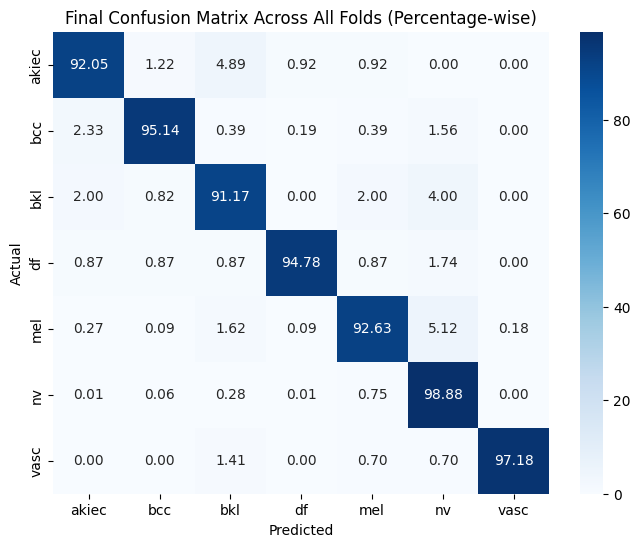

              precision    recall  f1-score   support

       akiec     0.8853    0.9205    0.9025       327
         bcc     0.9626    0.9514    0.9569       514
         bkl     0.9453    0.9117    0.9282      1099
          df     0.9478    0.9478    0.9478       115
         mel     0.9288    0.9263    0.9276      1113
          nv     0.9834    0.9888    0.9861      6705
        vasc     0.9857    0.9718    0.9787       142

    accuracy                         0.9685     10015
   macro avg     0.9484    0.9455    0.9468     10015
weighted avg     0.9685    0.9685    0.9685     10015



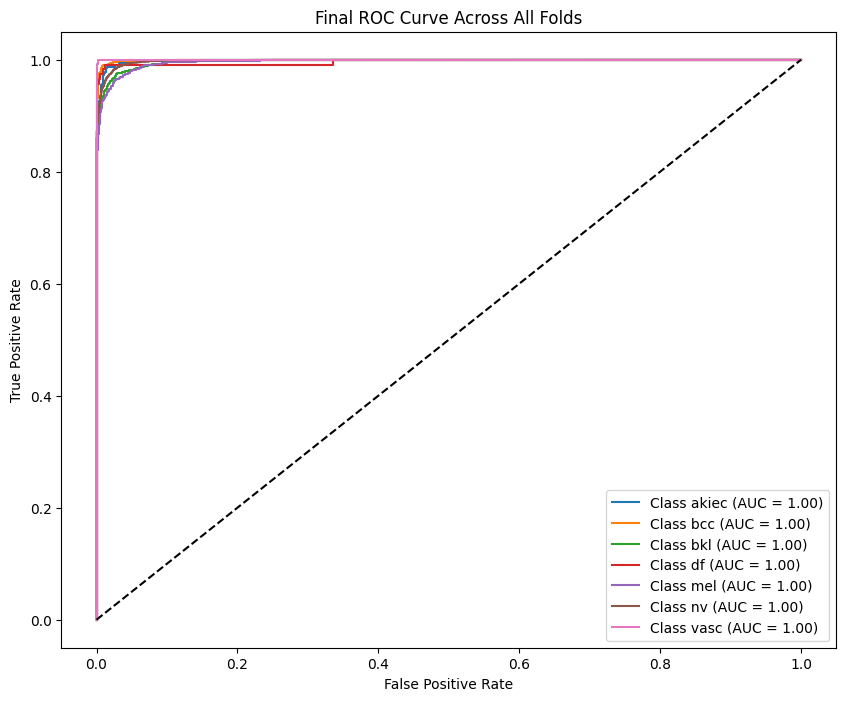

In [8]:

from sklearn.metrics import confusion_matrix
import numpy as np  # Ensure numpy is also imported
print("\n📊 Final Evaluation Across All Folds:")

cm = confusion_matrix(all_true_labels, all_pred_labels)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=base_dataset.class_to_idx.keys(), 
            yticklabels=base_dataset.class_to_idx.keys())

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Final Confusion Matrix Across All Folds (Percentage-wise)")
plt.show()

class_report = classification_report(all_true_labels, all_pred_labels, target_names=base_dataset.class_to_idx.keys(), digits=4)
print(class_report)

plt.figure(figsize=(10, 8))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(np.array(all_true_labels) == i, np.array(all_probs)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {list(base_dataset.class_to_idx.keys())[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Final ROC Curve Across All Folds")
plt.legend(loc="lower right")
plt.show()
